## Transition Count analysis using RMSD values from single trajectory 

### <center>1. Boring stuff first</center>
-----------------------------------------

#### 1.1 First, imports for analyzing trajectory data

In [1]:
# While things are changing alot
# autoreload is super helpful
%load_ext autoreload
%autoreload 2

# Builtins
import os
import itertools

# Installed
import pandas
import seaborn

%matplotlib inline

import matplotlib
plt = matplotlib.pyplot
#matplotlib.rcParams['font.family'] = 'serif'
#seaborn.set(font="Arial")
seaborn.set(font_scale=1.7)
seaborn.set_style("ticks", {"font.family" : ["serif"],
                            #"font.scale"  : "1.7",
                            "font.serif"  : ["Times New Roman"]})

#colorcycle = seaborn.husl_palette(14, l=.5)
#colorcycle = seaborn.cubehelix_palette(12, l=0.5)
#colorcycle = seaborn.color_palette("cubehelix", 12)[2:]
colorcycle = seaborn.color_palette("Set2", 8)
colorcycle2 = seaborn.color_palette("cubehelix", 12)
seaborn.palplot(colorcycle2)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colorcycle = prop_cycle.by_key()['color']

# Mine
from aswa_tools import (count_changes, mix_parameters,
    calculate_observed_rates,)

import aswanalysis

# TODO move the initialize to aswanalysis __init__.py
mdtraj = aswanalysis.mdtraj
plt = aswanalysis.plt
np = aswanalysis.np

#### 1.1.1 Create plots directory

In [2]:
from pathlib import Path

analysis_directory = Path("analysis-2state")

if not analysis_directory.is_dir():
    analysis_directory.mkdir()

#### 1.2 Set up for file reading

In [3]:
folded_file     = "topo/chignolin-folded.pdb"
top_file        = "topo/chignolin-protein.pdb"

traj_files      = ["openmm_longtraj/"+fnm for fnm in sorted(
    list(filter(
        lambda fnm: fnm.startswith('protein') and fnm.find("stride") < 0,
        os.listdir('./openmm_longtraj')
    )),
    key=lambda fnm: int(fnm.split('.')[1].split('-')[0])
)]

traj_files_amber = ["openmm_amber99/"+fnm for fnm in sorted(
    list(filter(
        lambda fnm: fnm.startswith('protein') and fnm.find("stride") < 0,
        os.listdir('./openmm_amber99')
    )),
    key=lambda fnm: int(fnm.split('.')[1].split('-')[0])
)]

traj_file_anton = "anton_longtraj/chignolin-anton-fixed-0.dcd"
top_file_anton  = "topo/chignolin-heavy.pdb"

#### 1.3 Other stuff to help clarify the data structure

In [4]:
label_heavies   = "Heavy Atoms RMSD [Å]"
label_alphies   = "Cα RMSD [Å]"
label_timesteps = "Time [μs]"

ns_per_step       = 0.020
us_per_step       = ns_per_step / 1000
us_per_step_anton = us_per_step * 10

### <center>2. RMSD Trajectory and Timeseries values to DataFrame</center>
---------------------------------------

#### 2.1 Our data

Charmm22*

In [5]:
traj = mdtraj.load(traj_files, top=top_file)

heavies = traj.topology.select("mass > 5")
alphies = traj.topology.select("name CA")

folded_heavies = mdtraj.load(folded_file)
folded_alphies = folded_heavies.atom_slice(
    folded_heavies.topology.select("name CA"))

traj_heavies   = traj.atom_slice(heavies)
traj_alphies   = traj.atom_slice(alphies)

traj_rmsd_df = pandas.DataFrame({
    label_heavies   : mdtraj.rmsd(traj_heavies, folded_heavies) * 10, #nm to angstrom
    label_alphies   : mdtraj.rmsd(traj_alphies, folded_alphies) * 10, #nm to angstrom
    label_timesteps : [i * us_per_step for i in range(len(traj))]
})

Amber99sbildn

In [6]:
traj_amber = mdtraj.load(traj_files_amber, top=top_file)

traj_heavies_amber   = traj_amber.atom_slice(heavies)
traj_alphies_amber   = traj_amber.atom_slice(alphies)

traj_rmsd_df_amber = pandas.DataFrame({
    label_heavies   : mdtraj.rmsd(traj_heavies_amber, folded_heavies) * 10, #nm to angstrom
    label_alphies   : mdtraj.rmsd(traj_alphies_amber, folded_alphies) * 10, #nm to angstrom
    label_timesteps : [i * us_per_step for i in range(len(traj_amber))]
})

#### 2.2 Anton data

In [7]:
traj_anton_heavies = mdtraj.load(traj_file_anton, top=top_file_anton)
traj_anton_alphies = traj_anton_heavies.atom_slice(
    traj_anton_heavies.topology.select("name CA"))

anton_rmsd_df = pandas.DataFrame({
    label_heavies   : mdtraj.rmsd(traj_anton_heavies, folded_heavies) * 10,
    label_alphies   : mdtraj.rmsd(traj_anton_alphies, folded_alphies) * 10,
    label_timesteps : [i * us_per_step_anton
        for i in range(len(traj_anton_heavies))]
})

### 3. Plot the RMSD Data
---------------------------------------

#### 3.1 Our data

Text(0.5, 1.0, 'OpenMM-Charm22* RMSD from Folded State')

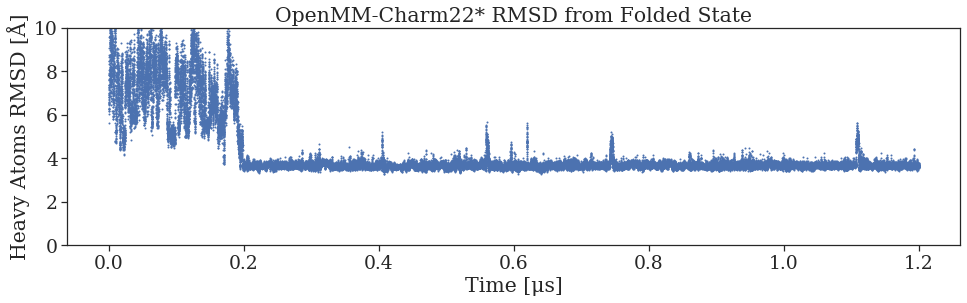

In [8]:
plt.close()
plt.figure(figsize=(16, 4))
omm_length = len(traj_rmsd_df[label_timesteps])
ax = seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][:int(1200*50)],
    y=traj_rmsd_df[label_heavies][:int(1200*50)],
    #x=traj_rmsd_df[label_timesteps][int(8*len(traj_rmsd_df[label_timesteps])/10):int(83*len(traj_rmsd_df[label_timesteps])/100)],
    #y=traj_rmsd_df[label_heavies][int(8*len(traj_rmsd_df[label_timesteps])/10):int(83*len(traj_rmsd_df[label_timesteps])/100)],
    
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_ylim(0,10)
ax.set_title("OpenMM-Charm22* RMSD from Folded State")

Text(0.5, 1.0, 'OpenMM RMSD from Folded State')

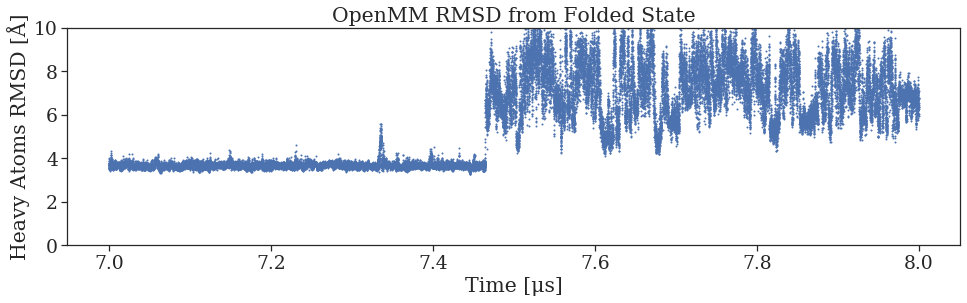

In [9]:
plt.close()
plt.figure(figsize=(16, 4))
omm_length = len(traj_rmsd_df[label_timesteps])
ax = seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][int(7000*50):int(8000*50)],
    y=traj_rmsd_df[label_heavies][int(7000*50):int(8000*50)],
    #x=traj_rmsd_df[label_timesteps][int(8*len(traj_rmsd_df[label_timesteps])/10):int(83*len(traj_rmsd_df[label_timesteps])/100)],
    #y=traj_rmsd_df[label_heavies][int(8*len(traj_rmsd_df[label_timesteps])/10):int(83*len(traj_rmsd_df[label_timesteps])/100)],
    
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_ylim(0,10)
ax.set_title("OpenMM RMSD from Folded State")

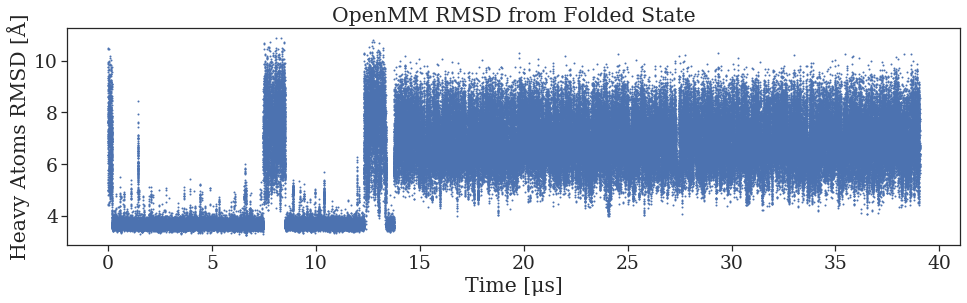

In [9]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][::10],
    y=traj_rmsd_df[label_heavies][::10],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_title("OpenMM RMSD from Folded State")
plt.savefig(analysis_directory / "rmsd-heavyatoms-omm-10us.png", dpi=1200)

In [21]:
traj_rmsd_df[label_heavies]

0          7.025952
1          6.965220
2          6.045566
3          6.281660
4          6.896564
             ...   
1952495    7.529308
1952496    7.566999
1952497    6.816199
1952498    7.227363
1952499    7.149052
Name: Heavy Atoms RMSD [Å], Length: 1952500, dtype: float32

In [23]:
traj_heavies[np.argmax(traj_rmsd_df[label_heavies])].save("chignolin-highrmsd.pdb")

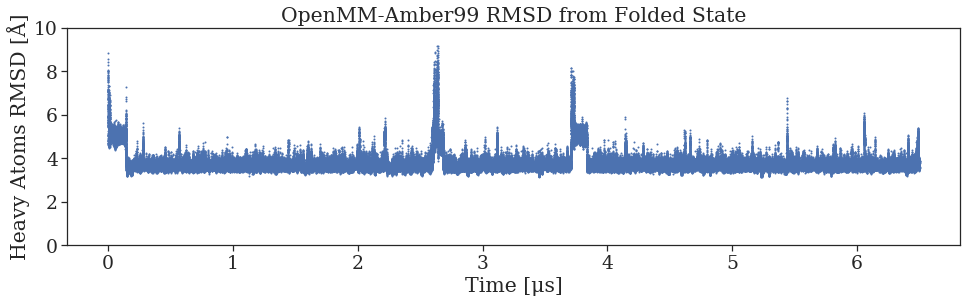

In [12]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=traj_rmsd_df_amber[label_timesteps],
    #x=range(len(traj_rmsd_df)),
    y=traj_rmsd_df_amber[label_heavies],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_ylim(0,10)
ax.set_title("OpenMM-Amber99 RMSD from Folded State")
plt.savefig(analysis_directory / "rmsd-heavies-omm_amber99-10us.png", dpi=1200)

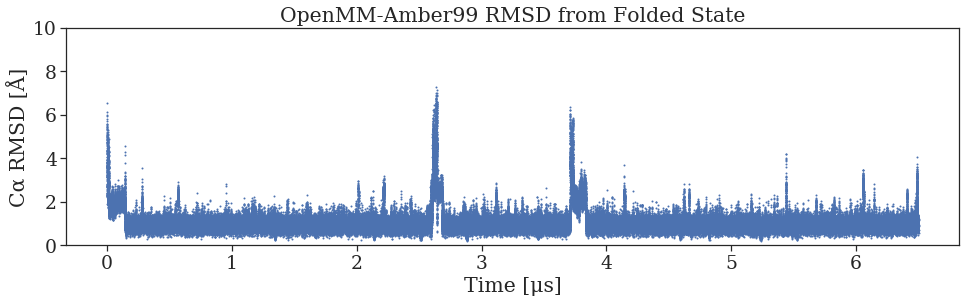

In [11]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=traj_rmsd_df_amber[label_timesteps],
    #x=range(len(traj_rmsd_df)),
    y=traj_rmsd_df_amber[label_alphies],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_ylim(0,10)
ax.set_title("OpenMM-Amber99 RMSD from Folded State")
plt.savefig(analysis_directory / "rmsd-Calpha-omm_amber99-10us.png", dpi=1200)

#### 3.2 Anton data
For comparison... this is the published RMSD plot with alpha carbons
![title](files/anton-ca-rmsd.png)

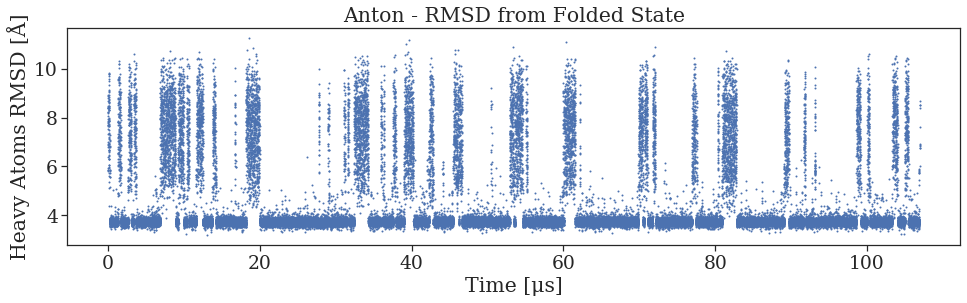

In [10]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=anton_rmsd_df[label_timesteps][::10],
    y=anton_rmsd_df[label_heavies][::10],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_title("Anton - RMSD from Folded State")
plt.savefig(analysis_directory / "rmsd-heavyatoms-anton-full.png", dpi=1200)

Text(0.5, 1.0, 'Anton - RMSD from Folded State')

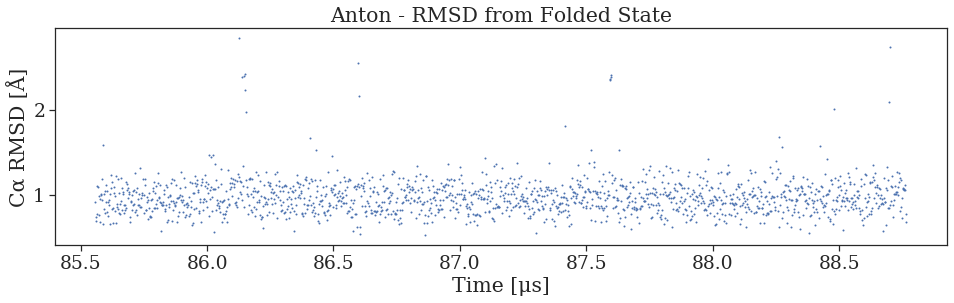

In [11]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=anton_rmsd_df[label_timesteps][int(8*len(anton_rmsd_df[label_timesteps])/10):int(83*len(anton_rmsd_df[label_timesteps])/100):10],
    y=anton_rmsd_df[label_alphies][int(8*len(anton_rmsd_df[label_timesteps])/10):int(83*len(anton_rmsd_df[label_timesteps])/100):10],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_title("Anton - RMSD from Folded State") 


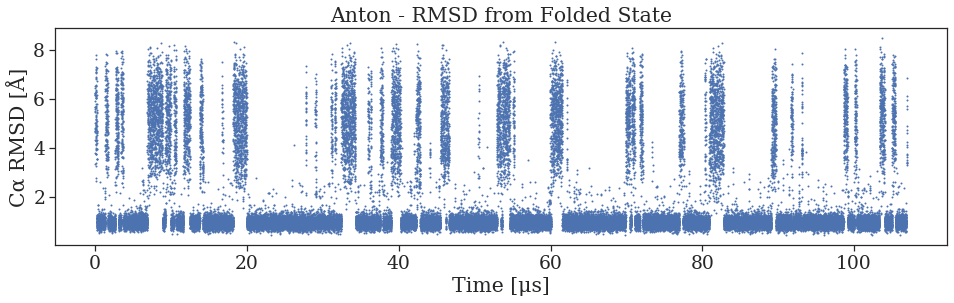

In [12]:
plt.close()
plt.figure(figsize=(16, 4))
ax = seaborn.scatterplot(
    x=anton_rmsd_df[label_timesteps][::10],
    y=anton_rmsd_df[label_alphies][::10],
    linewidth=0,
    s=4,
    #data=traj_rmsd_df,
    legend=False,
)
ax.set_title("Anton - RMSD from Folded State")
plt.savefig(analysis_directory / "rmsd-Calpha-anton-full.png", dpi=1200)

### 4. Dataframe from various transition counting schemes
---------------------------------------

#### 4.1 Array of parameter sets

In [13]:
# components
datasets      = {"OpenMM" : {"x" :  traj_rmsd_df[label_timesteps],
                             "y" :  traj_rmsd_df[label_alphies]},
                 "Anton"  : {"x" : anton_rmsd_df[label_timesteps],
                             "y" : anton_rmsd_df[label_alphies]},}

incr_length = 500
step_per_ns = {"OpenMM": 50,
               "Anton" : 5}

_n_incr = lambda data, incr_length: int(
    (len(data)/incr_length) + int(bool(len(data)%incr_length)))

n_incr = {dk: _n_incr(datasets[dk]["y"], incr_length)
    for dk in datasets}

ifcs_2state = [1.3, 3.]
ifcs_3state = [1.3, 2., 3.2, 4.5]
pars        = {"interfaces"    : [ifcs_2state, ifcs_3state],
               "min_residence" : [1, 3, 10, 25, 50, 100, 250, 500, 1000],}

# TODO FIXME this is terrible
parset_key = lambda parset: "_".join(
    ["{0}-{1}".format(p,v) for p,v in parset.items()])

# TODO FIXME mix_parameters return should be easier to use
parsets = mix_parameters(pars)
transition_data = dict()#pandas.DataFrame()
for dataname, dataset in datasets.items():
    parnames, parset = list(zip(*parsets.items()))
    for pars in zip(*parset):
        _pars = {k:v for k,v in list(zip(parnames, pars))}
        transition_data[dataname+"_"+parset_key(_pars)
        ] = [count_changes(dataset["y"], **_pars)]

#### 4.2 Timeseries of observed rates

In [14]:
# Gives units of inverse second
observed_rates = calculate_observed_rates(
    transition_data, incr_length, n_incr, step_per_ns)

observed_rates.update({
    label_timesteps : {
        dk : pandas.Series([
            ni * incr_length / step_per_ns[dk] / 1000
            for ni in range(n_incr[dk])
        ]) for dk in datasets}
})

#### 4.3 Slice out data we will use for plots from timeseries's

In [15]:
match_keys = lambda d,s: [
    key for key in d if key.find(s) > -1]

atn_2states = match_keys(match_keys(
    observed_rates, "Anton"), "1.3, 3.0")

omm_2states = match_keys(match_keys(
    observed_rates, "OpenMM"), "1.3, 3.0")

### 5. Plots of rate data
---------------------------------------

#### 5.1 OpenMM

##### 5.1.1 All Forward Rates (out of folded state)

<center>dirty version with all data</center>

Text(0, 0.5, 'MHz')

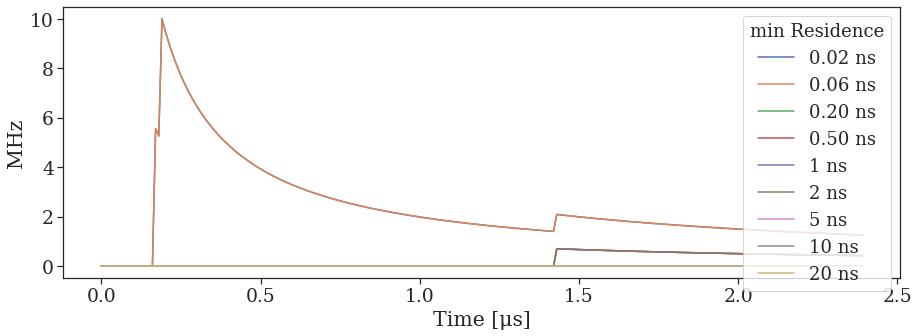

In [16]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 120000

for key in omm_2states:
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["forwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
    )

legend = plt.legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("MHz")

<center>clean version with representative data</center>

Text(0, 0.5, 's$^{-1}$')

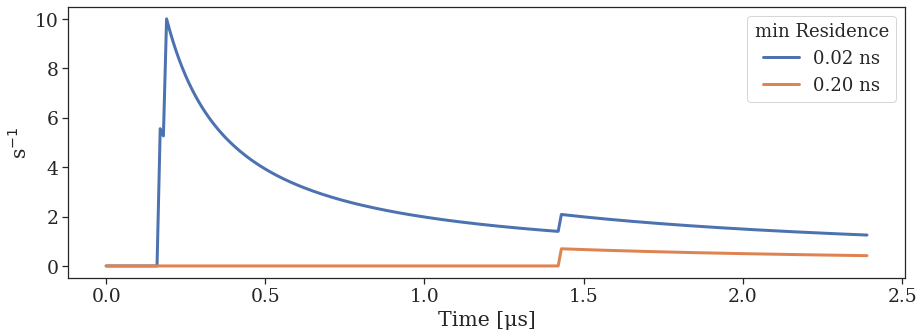

In [17]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 120000

# Only plotting guys who are:
#   - different from last
#   - non-zero somewhere
lastsum = -1
for key in omm_2states:
    _sum = np.sum(observed_rates[key]["forwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        lastsum = _sum
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["forwards"][:n_frames//incr_length],
        linewidth=3,
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
    )

legend = plt.legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
plt.ylabel("s$^{-1}$")
#plt.ylabel("MHz")

##### 5.1.2 All Backward Rates (into folded state)

<center>dirty version with all data</center>

Text(0, 0.5, 'MHz')

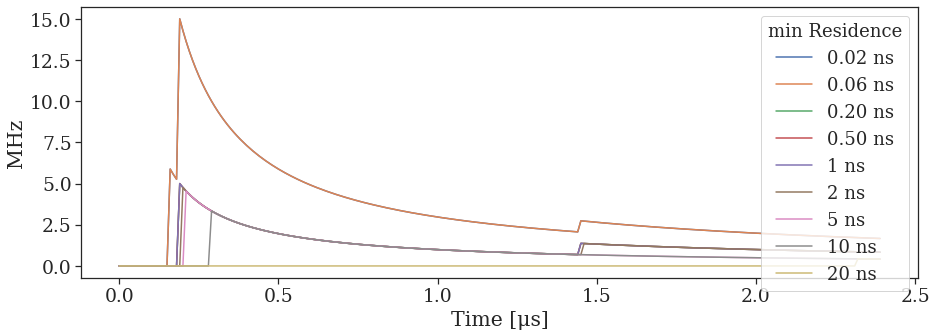

In [18]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 120000

for key in omm_2states:
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
    )

legend = plt.legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("MHz")

<center>clean version with representative data</center>

Text(0, 0.5, 'MHz')

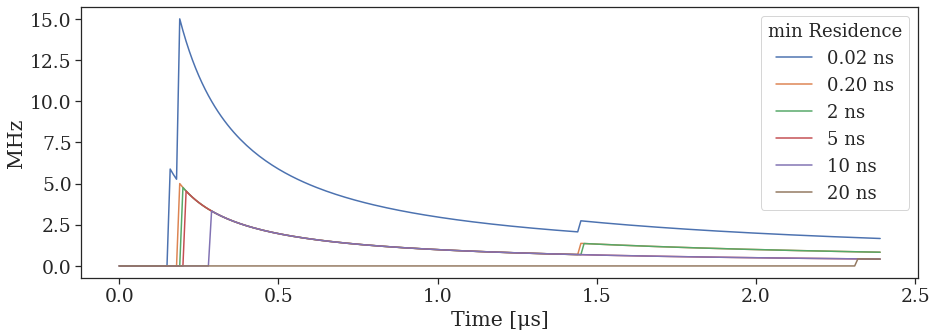

In [19]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 120000

# Only plotting guys who are:
#   - different from last
#   - non-zero somewhere
lastsum = -1
for key in omm_2states:
    _sum = np.sum(observed_rates[key]["backwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        lastsum = _sum
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
    )

legend = plt.legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("MHz")

##### 5.1.3 Selected Backward Rates showing the RMSD Transition vs Residence Time

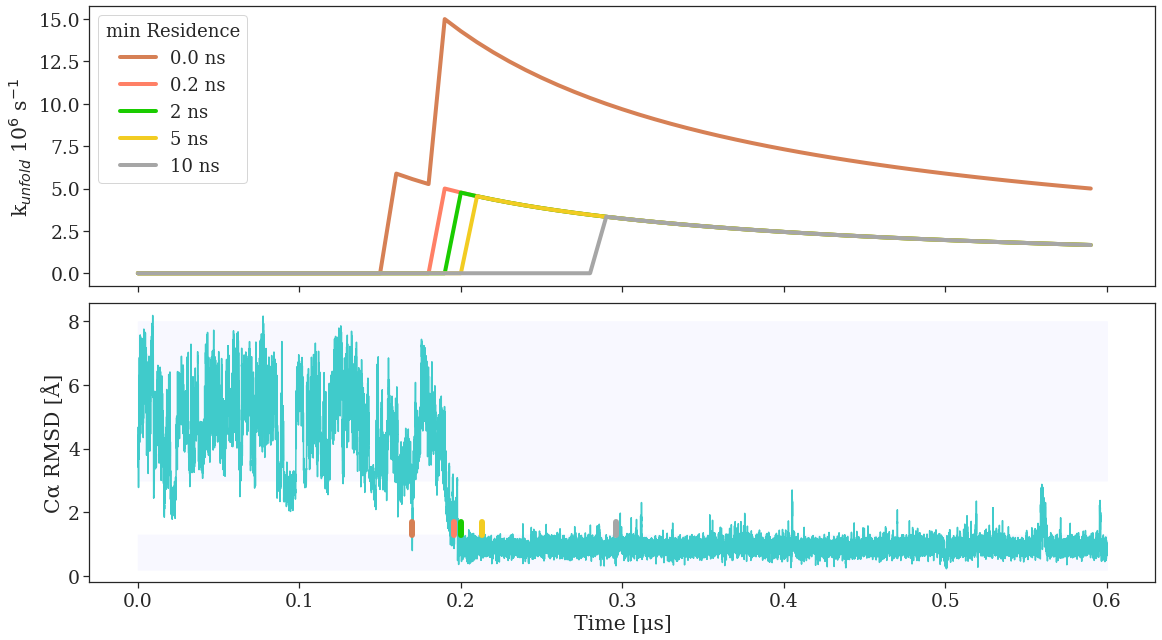

In [20]:
plt.close()
#plt.figure(figsize=(16,5))
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

interfaces    = ifcs_2state

# This stuff makes complicated plot...
# Values to help with extra plot objects
n_frames        = 30000
interfacecolor  = "ghostwhite"
timeseriescolor = [r+s for r,s in zip(matplotlib.colors.to_rgba("darkcyan"), (0.25, 0.25, 0.25, 0))]
shading_min     = 0.2
shading_max     = 8
arrow_linewidth = 6
arrow_length    = 0.4

class ColorCycler(object):
    _darken  = lambda c: [max(1e-4, sum(r)) for r in zip(c, (-0.05, -0.05, -0.05, 0))]
    _redder  = lambda f,c: [max(1e-4, sum(r)) for r in zip(c, (f*0.05, 0, 0, 0))]
    _lesred  = lambda f,c: [max(1e-4, sum(r)) for r in zip(c, (f*-0.05, 0, 0, 0))]
    _greener = lambda f,c: [max(1e-4, sum(r)) for r in zip(c, (0, f*0.05, 0, 0))]
    _colors = [
        _darken(_lesred(2, colorcycle[1])),
        (1, 0.5, 0.4, 1),#colorcycle[3])),
        _darken(_darken((0.2, 0.9, 0.1, 1))),#_darken(_greener(2, colorcycle[4])),
        _darken(colorcycle[5]),
        _darken(colorcycle[7]),
    ]
    def __len__(self):
        return len(self._colors)

    def __init__(self):
        super(ColorCycler, self).__init__()
        self._counter = -1

    def __next__(self):
        self._counter += 1
        return self._colors[self._counter % len(self)]


colorcycler = ColorCycler()

# Track the ones we will show for later
lastsum = -1
showthese = list()
for i,key in enumerate(omm_2states):
    _sum = np.sum(observed_rates[key]["backwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        showthese.append((i,key))
        lastsum = _sum
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.1f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
        linewidth=4,
        ax=axes[0],
        color=next(colorcycler),
    )
legend = axes[0].legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
axes[0].set_ylabel("k$_{unfold}$ 10$^6$ s$^{-1}$")

# Timeseries Values
seaborn.lineplot(
    x=traj_rmsd_df[label_timesteps][:n_frames],
    y=traj_rmsd_df[label_alphies][:n_frames],
    color=timeseriescolor,
    ax=axes[1]
)

_interfaces = [shading_min] + interfaces + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
#   - only looking at first transition into folded
for lookatme in showthese:
    i,lookatme = lookatme
    t = transition_data[lookatme][0][1][0][0]
    axes[1].plot(
        [t/50000, t/50000],
        [interfaces[0] + arrow_length, interfaces[0]],
        color=next(colorcycler),
        linewidth=arrow_linewidth,
    )

fig.tight_layout()
plt.savefig(analysis_directory / "rmsd-Calpha-changecount-calibration.png", dpi=1200)

#### 5.1.4 Anton Data backwards rates

<center>Rate Result for different Minimum Residence Times</center>

In [15]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 1200000

colorcycle = iter(seaborn.color_palette("husl", n_colors=10))

# Track the ones we will show for later
lastsum = -1
showthese = list()
for i,key in enumerate(omm_2states):
    _sum = np.sum(observed_rates[key]["backwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        showthese.append((i,key))
        lastsum = _sum
    seaborn.lineplot(
        x=observed_rates[label_timesteps]["OpenMM"],
        y=observed_rates[key]["backwards"],
        #x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        #y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.1f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
        color=next(colorcycle),
        linewidth=3,
    )

plt.ylim(-0.05, 3)
legend = plt.legend(fontsize='18', ncol=2, title="Minimum Residence Time")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")
plt.savefig(analysis_directory / "folding-observedrate-openmm-diffresidences-estimation-full.png", dpi=1200)

NameError: name 'omm_2states' is not defined

<Figure size 1080x360 with 0 Axes>

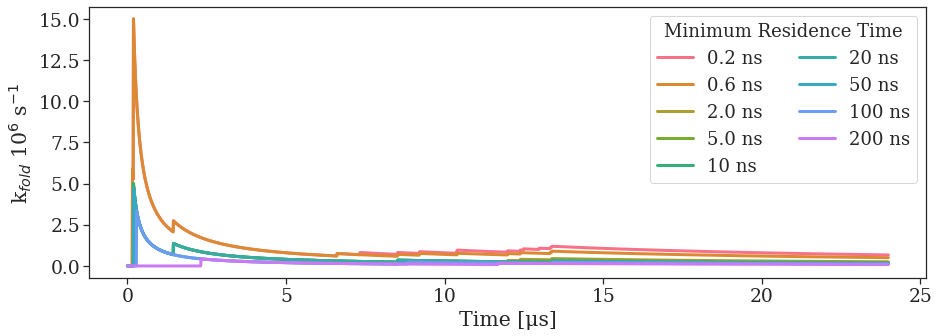

In [25]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 1200000

colorcycle = iter(seaborn.color_palette("husl", n_colors=10))

# Track the ones we will show for later
lastsum = -1
showthese = list()
for i,key in enumerate(omm_2states):
    _sum = np.sum(observed_rates[key]["backwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        showthese.append((i,key))
        lastsum = _sum
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.1f ns" % (
            0.2 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.2 * int(key.split("-")[-1])
        ),
        color=next(colorcycle),
        linewidth=3,
    )

legend = plt.legend(fontsize='18', ncol=2, title="Minimum Residence Time")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")
plt.savefig(analysis_directory / "folding-observedrate-anton-diffresidences-estimation-full.png", dpi=1200)

<center>The full length trajectory with 600 picosecond minimum residence time.</center>

<center><mark><span style="color:darkred"> Get the direct average state lifetimes </mark></span></center>

In [29]:
import pyemma
import aswa_tools
lag_time = 50 # 50 * 0.2ns = 10 ns

anton_dtraj = aswa_tools.dtraj_from_changepoints(
    transition_data["Anton_interfaces-[1.3, 3.0]_min_residence-50"],
    anton_rmsd_df[label_timesteps].shape[0]
)
openmm_dtraj = aswa_tools.dtraj_from_changepoints(
    transition_data["OpenMM_interfaces-[1.3, 3.0]_min_residence-500"],
    traj_rmsd_df[label_timesteps].shape[0]
)

anton_bmm = pyemma.msm.bayesian_markov_model(anton_dtraj, lag_time, reversible=False, dt_traj="0.2 ns")
openmm_bmm = pyemma.msm.bayesian_markov_model(openmm_dtraj, lag_time, reversible=False, dt_traj="0.2 ns")

#tpt_fwd = pyemma.msm.tpt(bmm, [0], [1])
#tpt_bwd = pyemma.msm.tpt(bmm, [1], [0])

#tpt_bwd.mfpt

In [47]:
(anton_dtraj[anton_dtraj==0].shape[0])/anton_dtraj.shape[0]

0.7784655432609684

In [45]:
(openmm_dtraj[openmm_dtraj==0].shape[0])/openmm_dtraj.shape[0]

0.4082284658040665

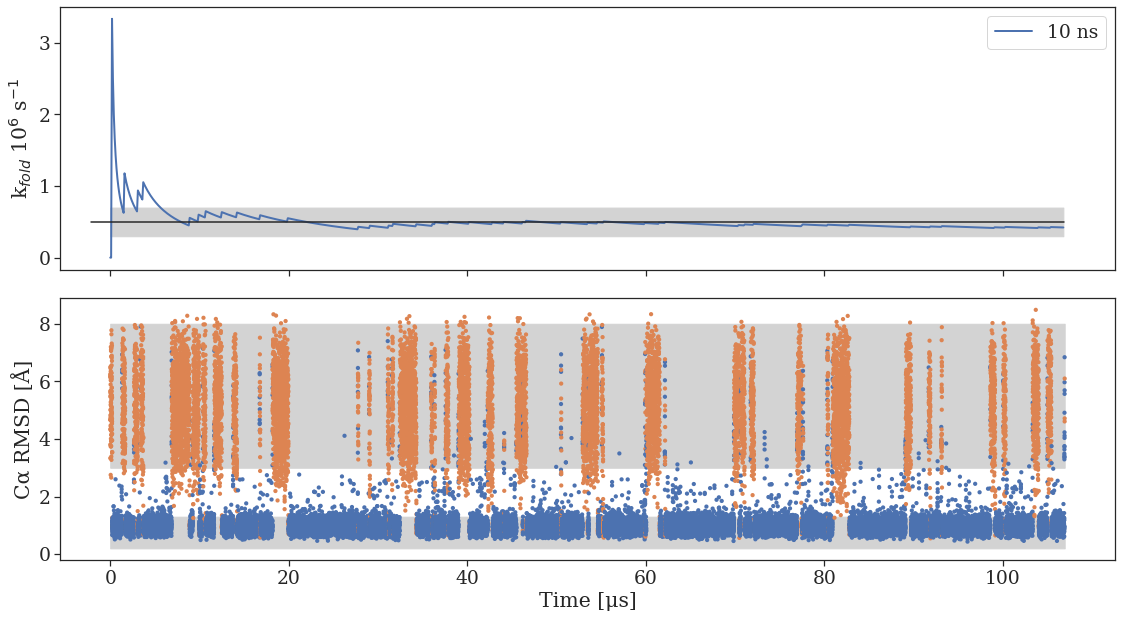

In [86]:
plt.close()
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

#n_frames = 12000
n_frames = -1
#lookatme = "Anton_interfaces-[1.3, 3.0]_min_residence-3"
lookatme = "Anton_interfaces-[1.3, 3.0]_min_residence-50"
interfacecolor  = "lightgrey"
#escapecolor    = "mediumseagreen"
#entercolor     = "indianred"
colorcycle = seaborn.color_palette("husl", n_colors=8)
escapecolor    = [min(1, np.sum(c)) for c in zip(colorcycle[0], (0.0, -0.09, -0.09, 0))]
entercolor     = [min(1, np.sum(c)) for c in zip(colorcycle[6], (-0.15, -0.15, -0.15, 0))]

seaborn.lineplot(
    #x=observed_rates[label_timesteps]["OpenMM"],
    #y=observed_rates[key]["forwards"],
    x=observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    y=observed_rates[lookatme]["backwards"][:n_frames//incr_length],
    # Hidden residence time calculation depends on
    # timestep, 20 picoseconds for OpenMM
    label="%.1f ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ) if int(lookatme.split("-")[-1]) < 49
    else "%d ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ),
    #color=,
    linewidth=2,
    ax=axes[0],
)

plt.xlabel(label_timesteps)
axes[0].set_ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")

# Timeseries Values
seaborn.scatterplot(
    x=anton_rmsd_df[label_timesteps][:n_frames:10],
    y=anton_rmsd_df[label_alphies][:n_frames:10],
    #color=timeseriescolor,
    hue=anton_dtraj[:n_frames:10],
    ax=axes[1],
    zorder=10,
    linewidth=0,
    legend=False,
    size=3,
)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = [-0.2, 0.2]
averagerate   = np.mean(observed_rates[lookatme]["backwards"])#[:n_frames//incr_length])
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    _exprateerror[0] + averagerate,
    _exprateerror[1] + averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        anton_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
#transitions = transition_data[lookatme]

#   - transition locations with arrow in transition direction
# Forwards first
#for transs in transitions[0][0]:
 #   for t in transs:
  #      if n_frames < 0 or t < n_frames:
   #         axes[1].plot(
    #            [t/5000, t/5000],
     #           [interfaces[1] - arrow_length, interfaces[1]],
      #          color=escapecolor,
       #         linewidth=arrow_linewidth,
        #        label="Unfold",
         #   )

## Backwards next
#for transs in transitions[0][1]:
 #   for t in transs:
  #      if n_frames < 0 or t < n_frames:
   #         axes[1].plot(
    #            [t/5000, t/5000],
     #           [interfaces[0] + arrow_length, interfaces[0]],
      #          color=entercolor,
       #         linewidth=arrow_linewidth,
        #        label="Fold",
         #   )

fig.tight_layout()
plt.savefig(analysis_directory / "folding-observedrate-anton-diffresidences-estimation-full.png", dpi=1200)

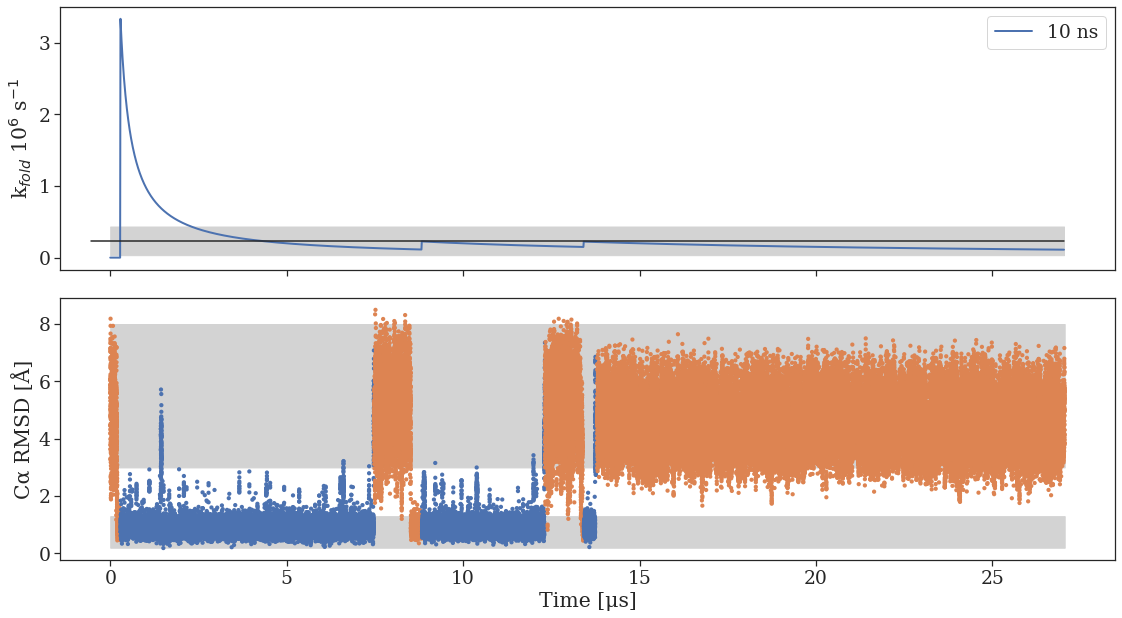

In [127]:
plt.close()
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

#n_frames = 12000
n_frames = -1
#lookatme = "Anton_interfaces-[1.3, 3.0]_min_residence-3"
lookatme = "OpenMM_interfaces-[1.3, 3.0]_min_residence-500"
interfacecolor  = "lightgrey"
#escapecolor    = "mediumseagreen"
#entercolor     = "indianred"
colorcycle = seaborn.color_palette("husl", n_colors=8)
escapecolor    = [min(1, np.sum(c)) for c in zip(colorcycle[0], (0.0, -0.09, -0.09, 0))]
entercolor     = [min(1, np.sum(c)) for c in zip(colorcycle[6], (-0.15, -0.15, -0.15, 0))]

seaborn.lineplot(
    #x=observed_rates[label_timesteps]["OpenMM"],
    #y=observed_rates[key]["forwards"],
    x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
    y=observed_rates[lookatme]["backwards"][:n_frames//incr_length],
    # Hidden residence time calculation depends on
    # timestep, 20 picoseconds for OpenMM
    label="%.1f ns" % (
        0.02 * int(lookatme.split("-")[-1])
    ) if int(lookatme.split("-")[-1]) < 49
    else "%d ns" % (
        0.02 * int(lookatme.split("-")[-1])
    ),
    #color=,
    linewidth=2,
    ax=axes[0],
)

plt.xlabel(label_timesteps)
axes[0].set_ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")

# Timeseries Values
seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][:n_frames:10],
    y=traj_rmsd_df[label_alphies][:n_frames:10],
    #color=timeseriescolor,
    hue=openmm_dtraj[:n_frames:10],
    ax=axes[1],
    zorder=10,
    linewidth=0,
    legend=False,
    size=3,
)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = [-0.2, 0.2]
averagerate   = np.mean(observed_rates[lookatme]["backwards"])#[:n_frames//incr_length])
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
    _exprateerror[0] + averagerate,
    _exprateerror[1] + averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
#transitions = transition_data[lookatme]

#   - transition locations with arrow in transition direction
# Forwards first
#for transs in transitions[0][0]:
 #   for t in transs:
  #      if n_frames < 0 or t < n_frames:
   #         axes[1].plot(
    #            [t/5000, t/5000],
     #           [interfaces[1] - arrow_length, interfaces[1]],
      #          color=escapecolor,
       #         linewidth=arrow_linewidth,
        #        label="Unfold",
         #   )

## Backwards next
#for transs in transitions[0][1]:
 #   for t in transs:
  #      if n_frames < 0 or t < n_frames:
   #         axes[1].plot(
    #            [t/5000, t/5000],
     #           [interfaces[0] + arrow_length, interfaces[0]],
      #          color=entercolor,
       #         linewidth=arrow_linewidth,
        #        label="Fold",
         #   )

fig.tight_layout()
plt.savefig(analysis_directory / "folding-observedrate-openmm-diffresidences-estimation-full.png", dpi=1200)

<center>Just the first bit to make sure everything looks like it matches up.

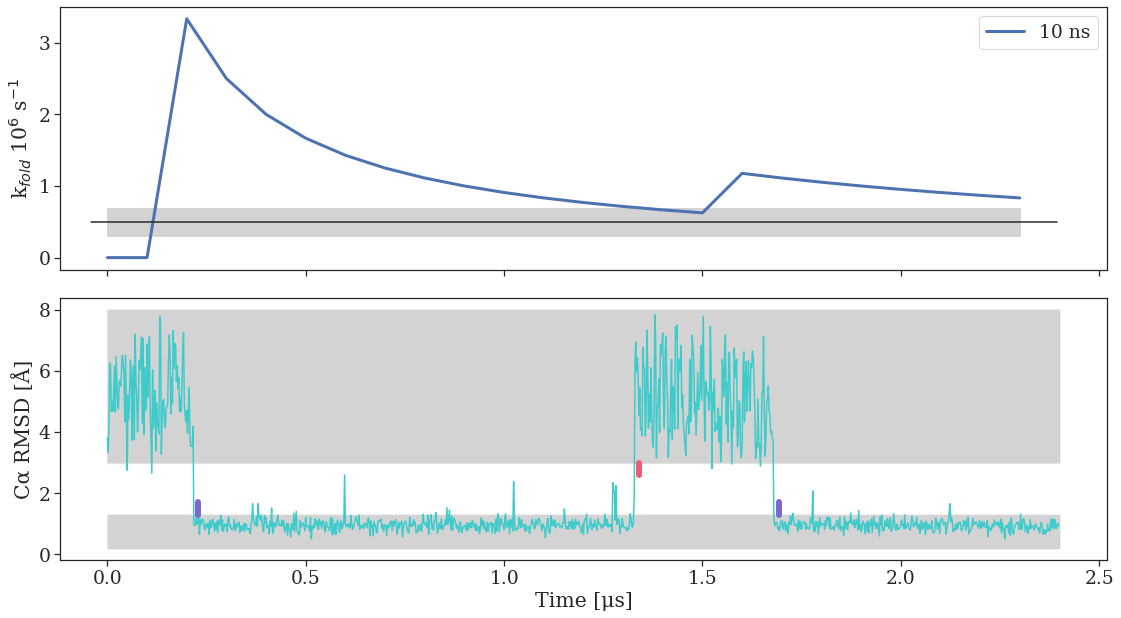

In [31]:
plt.close()
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

n_frames = 12000


seaborn.lineplot(
    #x=observed_rates[label_timesteps]["OpenMM"],
    #y=observed_rates[key]["forwards"],
    x=observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    y=observed_rates[lookatme]["backwards"][:n_frames//incr_length],
    # Hidden residence time calculation depends on
    # timestep, 20 picoseconds for OpenMM
    label="%.1f ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ) if int(lookatme.split("-")[-1]) < 49
    else "%d ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ),
    #color=,
    linewidth=3,
    ax=axes[0],
)

plt.xlabel(label_timesteps)
axes[0].set_ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")

# Timeseries Values
seaborn.lineplot(
    x=anton_rmsd_df[label_timesteps][:n_frames:10],
    y=anton_rmsd_df[label_alphies][:n_frames:10],
    color=timeseriescolor,
    ax=axes[1]
)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = [-0.2, 0.2]
averagerate   = np.mean(observed_rates[lookatme]["backwards"])#[:n_frames//incr_length])
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    _exprateerror[0] + averagerate,
    _exprateerror[1] + averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        anton_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
transitions = transition_data[lookatme]

#   - transition locations with arrow in transition direction
# Forwards first
for transs in transitions[0][0]:
    for t in transs:
        if n_frames < 0 or t < n_frames:
            axes[1].plot(
                [t/5000, t/5000],
                [interfaces[1] - arrow_length, interfaces[1]],
                color=escapecolor,
                linewidth=arrow_linewidth,
            )

## Backwards next
for transs in transitions[0][1]:
    for t in transs:
        if n_frames < 0 or t < n_frames:
            axes[1].plot(
                [t/5000, t/5000],
                [interfaces[0] + arrow_length, interfaces[0]],
                color=entercolor,
                linewidth=arrow_linewidth,
            )

fig.tight_layout()
plt.savefig(analysis_directory / "folding-observedrate-omm-closeup.png", dpi=1200)

<center>A bit more for more trend info</center>

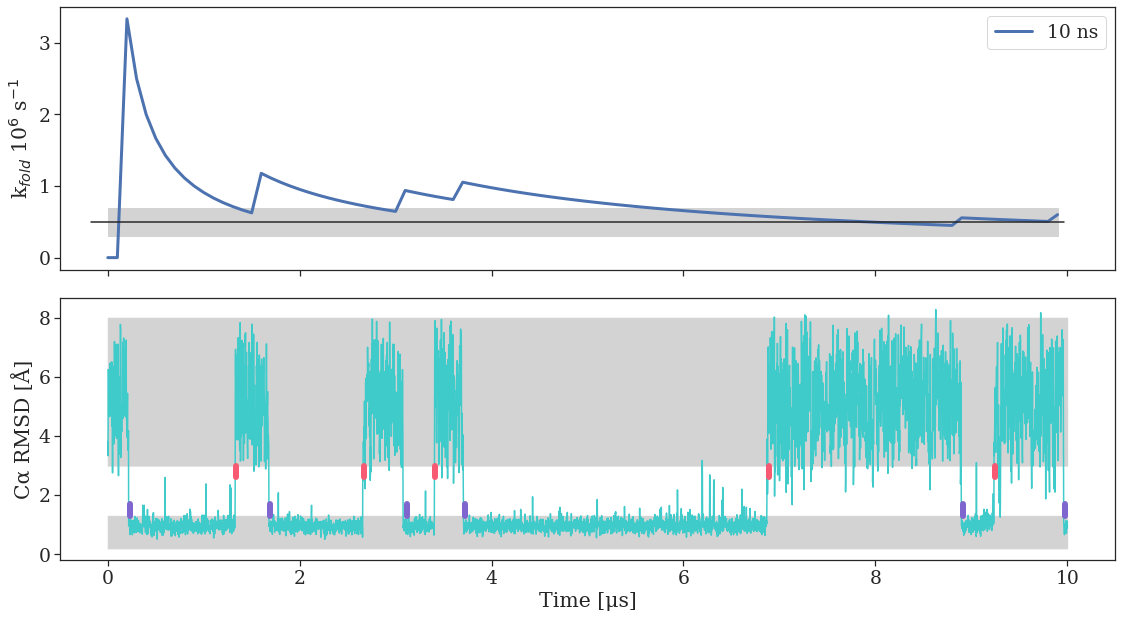

In [32]:
plt.close()
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

n_frames = 50000

seaborn.lineplot(
    #x=observed_rates[label_timesteps]["OpenMM"],
    #y=observed_rates[key]["forwards"],
    x=observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    y=observed_rates[lookatme]["backwards"][:n_frames//incr_length],
    # Hidden residence time calculation depends on
    # timestep, 20 picoseconds for OpenMM
    label="%.1f ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ) if int(lookatme.split("-")[-1]) < 49
    else "%d ns" % (
        0.2 * int(lookatme.split("-")[-1])
    ),
    #color=,
    linewidth=3,
    ax=axes[0],
)

plt.xlabel(label_timesteps)
axes[0].set_ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")

# Timeseries Values
seaborn.lineplot(
    x=anton_rmsd_df[label_timesteps][:n_frames:10],
    y=anton_rmsd_df[label_alphies][:n_frames:10],
    color=timeseriescolor,
    ax=axes[1]
)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = [-0.2, 0.2]
averagerate   = np.mean(observed_rates[lookatme]["backwards"])#[:n_frames//incr_length])
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
    _exprateerror[0] + averagerate,
    _exprateerror[1] + averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        anton_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
transitions = transition_data[lookatme]

#   - transition locations with arrow in transition direction
# Forwards first
for transs in transitions[0][0]:
    for t in transs:
        if n_frames < 0 or t < n_frames:
            axes[1].plot(
                [t/5000, t/5000],
                [interfaces[1] - arrow_length, interfaces[1]],
                color=escapecolor,
                linewidth=arrow_linewidth,
            )

## Backwards next
for transs in transitions[0][1]:
    for t in transs:
        if n_frames < 0 or t < n_frames:
            axes[1].plot(
                [t/5000, t/5000],
                [interfaces[0] + arrow_length, interfaces[0]],
                color=entercolor,
                linewidth=arrow_linewidth,
            )

fig.tight_layout()
plt.savefig(analysis_directory / "folding-observedrate-omm-10us.png", dpi=1200)

<center>All Rate Results from Anton</center>

# Workup Below

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

-----------------------  results above  --------------------------------------

### 2-State Change counting and plotting- Our Data

#### Counting

In [35]:
folding_interfaces = [0.13, 0.3]
required_residence = 20
n_frames = 100000

transitions = count_changes(
    traj_rmsd_df[label_alphies][:n_frames],
    folding_interfaces,
    required_residence,
)

#### Composite plot with RMSD Data

IndexError: list index out of range

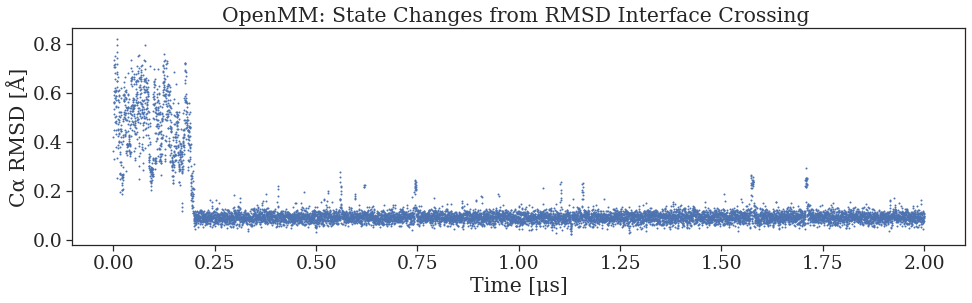

In [36]:
plt.close()

# Setup for code below, will become function soon!
# TODO make this into a function
sparseness  = 10
interfaces  = folding_interfaces
independent = traj_rmsd_df[label_timesteps][:n_frames:sparseness]
timeseries  = traj_rmsd_df[label_alphies][:n_frames:sparseness]

# Values to help with extra plot objects
vline_start = np.mean(interfaces)
t_min = 0
t_max = len(timeseries)

escapecolor    = "darkorange"
entercolor     = "magenta"
interfacecolor = "grey"

arrow_lw = 5
arrow_length = np.abs(interfaces[1] - interfaces[0]) / 4

# The raw data, sparsified
plt.figure(figsize=(16, 4))
#ax = seaborn.lineplot(
ax = seaborn.scatterplot(
    x=independent,
    #x=range(len(traj_rmsd_df)),
    y=timeseries,
    s=4,
    linewidth=0,
    legend=False,
)
ax.set_title(
    ("OpenMM: State Changes from RMSD Interface Crossing "
     ""
     #"(%s ps res, %.3f I1, %.3f I2)" % 
     #(required_residence, *folding_interfaces)
    )
)

# Extra plot objects:
#   - transition locations with arrow in transition direction
[
    #ax.plot([independent[(int(t/sparseness)*sparseness)], independent[(int(t/sparseness)*sparseness)]], [vline_start, interfaces[1]], color=escapecolor)
    ax.plot(
        [independent[t-t%10], independent[t-t%10]],
        [vline_start, interfaces[1] - arrow_length / 3],
        color=escapecolor,
        linewidth=arrow_lw,
        zorder=10,
    )
    for t in transitions[0][0]
]
[
    ax.arrow(
        independent[t-t%10], interfaces[1] - arrow_length, 0, arrow_length,
        color=escapecolor,
        shape='full',
        linewidth=0,
        length_includes_head=True,
        head_length=arrow_length,
        head_width=0.1,
        zorder=15,
    )
    for t in transitions[0][0]
]
[
    #ax.plot([independent[(int(t/sparseness)*sparseness)], independent[(int(t/sparseness)*sparseness)]], [vline_start, interfaces[1]], color=escapecolor)
    ax.plot(
        [independent[t-t%10], independent[t-t%10]],
        [vline_start, interfaces[0] + arrow_length / 3],
        color=entercolor,
        linewidth=arrow_lw,
        zorder=15,
    )
    for t in transitions[0][1]
]
[
    ax.arrow(
        independent[t-t%10], interfaces[0] + 0.05, 0, - 0.05,
        color=entercolor,
        shape='full',
        linewidth=0,
        length_includes_head=True,
        head_length=arrow_length,
        head_width=0.1,
        zorder=10,
    )
    for t in transitions[0][1]
]

#   - transition interface locations
plt.axhline(interfaces[0], t_min, t_max, ls="--", color=interfacecolor)
plt.axhline(interfaces[1], t_min, t_max, ls="--", color=interfacecolor)

plt.savefig(analysis_directory / "rmsd-openmm-2state-arrow.png", dpi=1200)

### 2-State Change counting and plotting- Anton Data

#### Counting

In [43]:
folding_interfaces = [0.13, 0.3]
required_residence = 2
n_frames = 10000

transitions = count_changes(
    anton_rmsd_df[label_alphies][:n_frames],
    folding_interfaces,
    required_residence,
)

#### Composite plot with RMSD Data

TypeError: unsupported operand type(s) for %: 'list' and 'int'

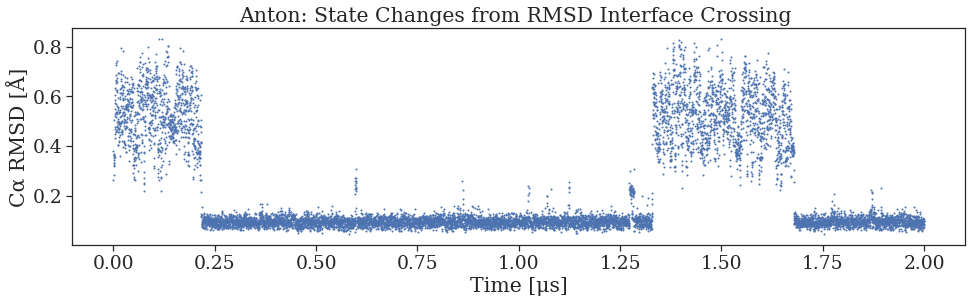

In [44]:
plt.close()

# Setup for code below, will become function soon!
# TODO make this into a function
sparseness  = 1
interfaces  = folding_interfaces
independent = anton_rmsd_df[label_timesteps][:n_frames:sparseness]
timeseries  = anton_rmsd_df[label_alphies][:n_frames:sparseness]

# Values to help with extra plot objects
vline_start = np.mean(interfaces)
t_min = 0
t_max = len(timeseries)

escapecolor    = "darkorange"
entercolor     = "magenta"
interfacecolor = "grey"

arrow_lw = 5
arrow_length = np.abs(interfaces[1] - interfaces[0]) / 4

# The raw data, sparsified
plt.figure(figsize=(16, 4))
#ax = seaborn.lineplot(
ax = seaborn.scatterplot(
    x=independent,
    #x=range(len(traj_rmsd_df)),
    y=timeseries,
    s=4,
    linewidth=0,
    legend=False,
)
ax.set_title(
    ("Anton: State Changes from RMSD Interface Crossing "
     ""
     #"(%s ps res, %.3f I1, %.3f I2)" % 
     #(required_residence, *folding_interfaces)
    )
)

# Extra plot objects:
#   - transition locations with arrow in transition direction
[
    #ax.plot([independent[(int(t/sparseness)*sparseness)], independent[(int(t/sparseness)*sparseness)]], [vline_start, interfaces[1]], color=escapecolor)
    ax.plot(
        [independent[t-t%10], independent[t-t%10]],
        [vline_start, interfaces[1] - arrow_length / 3],
        color=escapecolor,
        linewidth=arrow_lw,
        zorder=10,
    )
    for t in transitions[0]
]
[
    ax.arrow(
        independent[t-t%10], interfaces[1] - arrow_length, 0, arrow_length,
        color=escapecolor,
        shape='full',
        linewidth=0,
        length_includes_head=True,
        head_length=arrow_length,
        head_width=0.1,
        zorder=15,
    )
    for t in transitions[0]
]
[
    #ax.plot([independent[(int(t/sparseness)*sparseness)], independent[(int(t/sparseness)*sparseness)]], [vline_start, interfaces[1]], color=escapecolor)
    ax.plot(
        [independent[t-t%10], independent[t-t%10]],
        [vline_start, interfaces[0] + arrow_length / 3],
        color=entercolor,
        linewidth=arrow_lw,
        zorder=15,
    )
    for t in transitions[1]
]
[
    ax.arrow(
        independent[t-t%10], interfaces[0] + 0.05, 0, - 0.05,
        color=entercolor,
        shape='full',
        linewidth=0,
        length_includes_head=True,
        head_length=arrow_length,
        head_width=0.1,
        zorder=10,
    )
    for t in transitions[1]
]

#   - transition interface locations
plt.axhline(interfaces[0], t_min, t_max, ls="--", color=interfacecolor)
plt.axhline(interfaces[1], t_min, t_max, ls="--", color=interfacecolor)

plt.savefig(analysis_directory / "rmsd-anton-2state-arrow.png", dpi=1200)

### Multi-State Change counting from RMSD data

In [148]:
folding_interfaces = [0.12, 0.2, 0.32, 0.45]
#folding_interfaces = [0.12, 0.2, 0.35, 0.4, 0.55]
required_residence = 10
n_frames = 20000

from count_changes import count_changes_Nstate
transitions = count_changes_Nstate(
    traj_rmsd_df[label_alphies][:n_frames],
    folding_interfaces,
    required_residence,
)

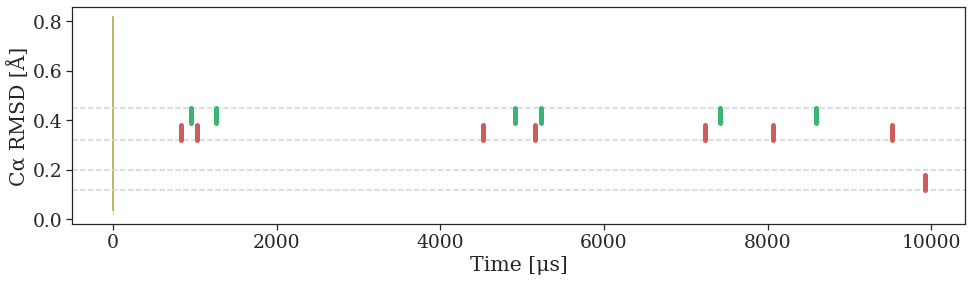

In [149]:
plt.close()
plt.figure(figsize=(16, 4))

interfaces = folding_interfaces
n_frames   = 12000

# Values to help with extra plot objects
t_min = 0
t_max = n_frames
escapecolor    = "mediumseagreen"
entercolor     = "indianred"
interfacecolor = "lightgrey"
timeseriescolor= "darkkhaki"

shading_min = 0.02
shading_max = 0.8

arrow_linewidth = 5
arrow_length    = 0.06

# Timeseries Values
ax = seaborn.lineplot(
    x=traj_rmsd_df[label_timesteps][:n_frames],
    y=traj_rmsd_df[label_alphies][:n_frames],
    color=timeseriescolor,
)

_interfaces = [shading_min] + interfaces + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    ax.fill_between(
        traj_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

[plt.axhline(ifc, t_min, t_max, ls="--", color=interfacecolor) for ifc in interfaces]

# Extra plot objects:
#   - transition locations with arrow in transition direction
# Forwards first
for ifcidx, cg in enumerate(transitions[0]):
    #vline_start = np.mean([interfaces[2*ifcidx+1], interfaces[2*ifcidx]])
    for t in cg:
        plt.plot(
            [t, t],
            [interfaces[2*ifcidx+1] - arrow_length, interfaces[2*ifcidx+1]],
            color=escapecolor,
            linewidth=arrow_linewidth,
        )

# Backwards next
for ifcidx, cg in enumerate(transitions[1]):
    #vline_start = np.mean([interfaces[2*ifcidx+1], interfaces[2*ifcidx]])
    for t in cg:
        plt.plot(
            [t, t],
            [interfaces[2*ifcidx], interfaces[2*ifcidx] + arrow_length],
            color=entercolor,
            linewidth=arrow_linewidth,
        )
#[
#    plt.arrow(
#        t, interfaces[1] - 0.25, 0, 0.25,
#        color=escapecolor,
#        shape='full',
#        linewidth=0,
#        length_includes_head=True,
#        head_length=0.3,
#        head_width=1,
#        zorder=10,
#    )
#    for t in transitions[0]
#]

#### OpenMM first part of traj with rates and RMSD for inspecting

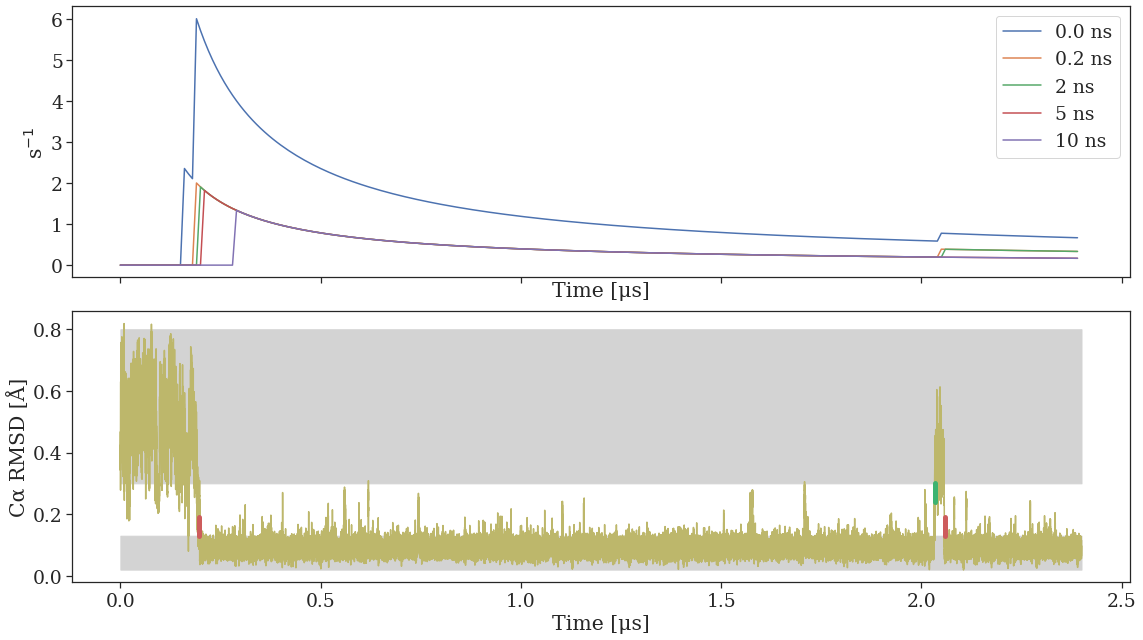

In [19]:
plt.close()
#plt.figure(figsize=(16,5))
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

lookatthisone = "OpenMM_interfaces-[0.13, 0.3]_min_residence-10"
interfaces    = ifcs_2state
transitions   = transition_data[lookatthisone]

# This stuff makes complicated plot...
# Values to help with extra plot objects
n_frames        = 120000
escapecolor     = "mediumseagreen"
entercolor      = "indianred"
interfacecolor  = "lightgrey"
timeseriescolor = "darkkhaki"
shading_min     = 0.02
shading_max     = 0.8
arrow_linewidth = 5
arrow_length    = 0.06

# Track the ones we will show for later
lastsum = -1
showthese = list()
for key in omm_2states:
    _sum = np.sum(observed_rates[key]["backwards"][:n_frames//incr_length])
    if not _sum:
        continue
    elif abs(_sum - lastsum) < 1e-4:
        continue
    else:
        showthese.append(key)
        lastsum = _sum
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["OpenMM"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.1f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
        ax=axes[0],
    )

    axes[0].set_xlabel(label_timesteps)
    axes[0].set_ylabel("s$^{-1}$")

# Timeseries Values
seaborn.lineplot(
    x=traj_rmsd_df[label_timesteps][:n_frames],
    y=traj_rmsd_df[label_alphies][:n_frames],
    color=timeseriescolor,
    ax=axes[1]
)

_interfaces = [shading_min] + interfaces + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
#   - transition locations with arrow in transition direction
# Forwards first
for transs in transitions[0][0]:
    for t in transs:
        axes[1].plot(
            [t/50000, t/50000],
            [interfaces[1] - arrow_length, interfaces[1]],
            color=escapecolor,
            linewidth=arrow_linewidth,
        )

## Backwards next
for transs in transitions[0][1]:
    for t in transs:
        axes[1].plot(
            [t/50000, t/50000],
            [interfaces[0] + arrow_length, interfaces[0]],
            color=entercolor,
            linewidth=arrow_linewidth,
        )

fig.tight_layout()

TypeError: unhashable type: 'slice'

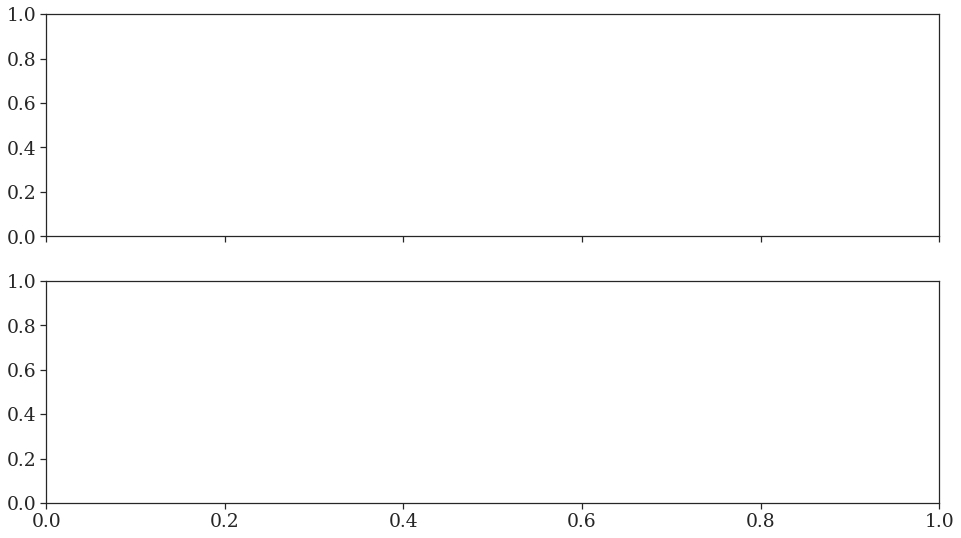

In [20]:
plt.close()
#plt.figure(figsize=(16,5))
fig, axes = plt.subplots(2,1,figsize=(16,9), sharex=True)

lookatthisone = "Anton_interfaces-[0.13, 0.3]_min_residence-10"
interfaces    = ifcs_2state
transitions   = transition_data[lookatthisone]

# This stuff makes complicated plot...
# Values to help with extra plot objects
n_frames        = 12000
escapecolor     = "mediumseagreen"
entercolor      = "indianred"
interfacecolor  = "lightgrey"
timeseriescolor = "darkkhaki"
shading_min     = 0.02
shading_max     = 0.8
arrow_linewidth = 5
arrow_length    = 0.06

class ColorCycler(object):
    _lighten = lambda c: [sum(r) for r in zip(c, (0.05, 0.05, 0.05, 0))]
    _darken = lambda c: [sum(r) for r in zip(c, (-0.05, -0.05, -0.05, 0))]
    _colors = [
        _lighten(colorcycle2[1]),
        _lighten(colorcycle2[2]),
        colorcycle2[3],
        colorcycle2[4],
        colorcycle2[5],
        colorcycle2[6],
        colorcycle2[7],
        colorcycle2[8],
        colorcycle2[9],
    ]
    def __len__(self):
        return len(self._colors)
    def __init__(self):
        super(ColorCycler, self).__init__()
        self._counter = -1
    def __next__(self):
        self._counter += 1
        return self._colors[self._counter % len(self)]

colorcycler = ColorCycler()

# skipping zero measured count at end
#for key in atn_2states[:-2]:
for key in atn_2states[0],atn_2states[1],atn_2states[5],atn_2states[6]:
    #seaborn.lineplot(
    seaborn.scatterplot(
        x=observed_rates[label_timesteps]["Anton"][:200],
        y=observed_rates[key][:200],
        # Hidden residence time calculation depends on
        # timestep, 200 picoseconds for OpenMM
        label="%.1f ns" % (
            0.2 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.2 * int(key.split("-")[-1])
        ),
        linewidth=0,
    )
    plt.xlabel(label_timesteps)
    plt.ylabel("s$^{-1}$")

# Timeseries Values
seaborn.lineplot(
    x=traj_rmsd_df[label_timesteps][:n_frames],
    y=traj_rmsd_df[label_alphies][:n_frames],
    color=timeseriescolor,
    ax=axes[1]
)

_interfaces = [shading_min] + interfaces + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces)//2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:n_frames],
        _interfaces[2*i],
        _interfaces[2*i+1],
        color=interfacecolor,
    )

# Extra plot objects:
#   - transition locations with arrow in transition direction
# Forwards first
for transs in transitions[0][0]:
    for t in transs:
        axes[1].plot(
            [t/50000, t/50000],
            [interfaces[1] - arrow_length, interfaces[1]],
            color=escapecolor,
            linewidth=arrow_linewidth,
        )

## Backwards next
for transs in transitions[0][1]:
    for t in transs:
        axes[1].plot(
            [t/50000, t/50000],
            [interfaces[0] + arrow_length, interfaces[0]],
            color=entercolor,
            linewidth=arrow_linewidth,
        )

fig.tight_layout()

In [ ]:
plt.close()
plt.figure(figsize=(15,5))

n_frames = 120000

for key in atn_2states:
    seaborn.lineplot(
        #x=observed_rates[label_timesteps]["OpenMM"],
        #y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps]["Anton"][:n_frames//incr_length],
        y=observed_rates[key]["backwards"][:n_frames//incr_length],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (
            0.02 * int(key.split("-")[-1])
        ) if int(key.split("-")[-1]) < 49
        else "%d ns" % (
            0.02 * int(key.split("-")[-1])
        ),
        linewidth=2,
    )

#_interfaces = [shading_min] + interfaces + [shading_max]
##   - transition interface locations
#for i in range(len(_interfaces)//2):
 #   axes[1].fill_between(
  #      traj_rmsd_df[label_timesteps][:n_frames],
   #     _interfaces[2*i],
    #    _interfaces[2*i+1],
   #     color=interfacecolor,
  #  )

legend = plt.legend(fontsize='18', title="min Residence")
legend.get_title().set_fontsize('18')
plt.xlabel(label_timesteps)
#plt.ylabel("s$^{-1}$")
plt.ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")